# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

### Attention!
* For tasks where <ins>text answer</ins> is required **Russian language** is **allowed**.
* If a task asks you to describe something (make coclusions) then **text answer** is **mandatory** and **is** part of the task
* **Do not** upload the dataset to the grading system (we already have it)
* We **only** accept **ipynb** notebooks. If you use Google Colab then you'll have to download the notebook before passing the homework
* **Do not** use python loops instead of NumPy vector operations over NumPy vectors - it significantly decreases performance (see why https://blog.paperspace.com/numpy-optimization-vectorization-and-broadcasting/), will be punished with -0.25 for **every** task. 


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hands. 

### Task 1 <a id="task1"></a> (0.5 points)

Implement the function `H()` which calculates impurity criterion. We will be training regression tree, therefore, impurity criterion will be variance.

* You cannot use loops
* If `y` is empty, the function should return 0

In [3]:
def H(y):
    """
    Calculate impurity criterion
    
    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if len(y) == 0:
        return 0
    #чтобы посчитать дисперсию, нужно взять мат ожидание от квадрата разности значений и мат ожидания. То есть
    #V[y] = E[(y-E(y))^2]
    E_y = np.mean(y)
    return np.mean(np.power(y-E_y, 2))

In [4]:
# Test the function
assert np.allclose(H(np.array([4,2,2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [5]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node 
    y : ndarray
        array of target values in the node 
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """   
    #До порога и после (слева и справа)
    R_l = y[X[:,j] <= t]
    R_r = y[X[:,j] > t]
    #Считаем взвешенную сумму по формуле выше
    Q = len(R_l)*H(R_l)/len(X) + len(R_r)*H(R_r)/len(X)
    return Q

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [6]:
class Node(object):
    """
    Class for a decision tree node.
    
    Parameters
    ----------
    right : Node() or None
        Right child
    right : Node() or None
        Left child
    threshold: float
        
    column: int
        
    depth: int
        
    prediction: float
        prediction of the target value in the node (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """    
    def __init__(self):        
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None
        
    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'.format(self.column, self.threshold, self.prediction)
        return node_desc

In [7]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """ 
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
    
    def _more_tags(self):
        return {
            'requires_y': False
        }
            
    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node. 
        Try all features and thresholds. 
        
        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels. 
            
        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child. 
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child. 
        """
        
        # To store best split parameters
        best_split_column = None
        best_threshold = None
        # without splitting
        best_cost = H(y) 
        
        X_left = None
        y_left = None
        X_right = None
        y_right = None
        
        #Далее код взят частично из семинара 7
        
        # Нужно минимизировать функцию Q, чтобы найти лучшее разбиение
        for column_index in range(X.shape[1]):
            #Выбираем все значения колонки
            x_col = X[:, column_index]
            for i_x in range(len(x_col)):
                threshold = x_col[i_x]
                #Если нашли разбиение лучше, чем было, то меняем параметры
                Q_cur = Q(X, y, column_index, threshold)
                if  Q_cur < best_cost:
                    best_cost = Q_cur
                    y_right = y[x_col > threshold]
                    y_left = y[x_col <= threshold]
                    X_right = X[x_col > threshold]
                    X_left = X[x_col <= threshold]
                    best_split_column = column_index
                    best_threshold = threshold
        
        
        return best_split_column, best_threshold, X_left, y_left, X_right, y_right
    
    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth` and `min_samples_split` parameters for a given node. 
        
        Parameters
        ----------
        node : Node, 
            
        y : ndarray, shape (n_objects, )
            Object labels. 
            
        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:    
            return True
        if len(y) < self.min_samples_split:   
            return True
        return False
        
    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects 
        y : ndarray, shape (n_objects)
            Labels
        """
        
        if self.is_terminal(node, y):
            node.is_terminal =True
            return
        if len(np.unique(y)) == 1:
            node.is_terminal = True
            return
        split_column, threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)
        
        if split_column is None:
            node.is_terminal = True
            return
        
        #Чтобы получилось совсем хорошо (как на семинаре, +- как встроенная реализация),
        #я добавила параметр в конструктор min_samples_leaf
        if len(X_left) < self.min_samples_leaf or len(X_right) < self.min_samples_leaf:
            node.is_terminal = True
            return
        
        
        node.column = split_column
        node.threshold = threshold
        
        #так как ущел не terminal, то добавляем детей
        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.prediction = np.mean(y_left)
        
        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.prediction = np.mean(y_right)
        
        self.grow_tree(node.right, X_right, y_right)
        self.grow_tree(node.left, X_left, y_left)

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.
            
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        # Check the input
        if y is None:
            raise ValueError('Y should not be None')
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        self.n_features_in_ = X.shape[1]
        
        # Initialize the tree (root node, depth = 0)
        self.tree_ = Node()                             
        self.tree_.depth = 0                            
        self.tree_.prediction = np.mean(y)
        
        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self        
    
    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get predictions of the proper child
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """
        if node.is_terminal:    
            return node.prediction
        if x[node.column] > node.threshold:
            y_pred = self.get_prediction(node.right, x)
        else:
            y_pred = self.get_prediction(node.left, x)
        return y_pred
    
    def predict(self, X):
        """ 
        Get prediction for each object in X
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        
        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [8]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($70\%$) and test ($30\%$). Fit Decision Tree of depth 1 and make the following plot:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model 

P.S. Depth of the tree is equal to the longest path from the root note to the leaf. Thus, tree with depth 1 will have exactly 1 split. 

P.P.S. Both fitted model and the training points should be on the same plot

In [9]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

data = load_boston()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

DecisionTree = MyDecisionTreeRegressor(max_depth = 1)
DecisionTree.fit(X_train, y_train)

MyDecisionTreeRegressor(max_depth=1)

In [10]:
#Видно, что если взять tree_, tree_.right/left и так далее, то можно узнать колонку разделения и порог
DecisionTree.tree_

Col 5, t 6.94, Pred: 23.02

In [11]:
DecisionTree.tree_.threshold

6.939

In [12]:
print(DecisionTree.tree_.left.prediction)
print(DecisionTree.tree_.right.prediction)

20.083904109589042
36.82419354838709


In [13]:
col = DecisionTree.tree_.column
threshold = DecisionTree.tree_.threshold
X_l = X_train[X_train[:, col] <= threshold]
y_l = y_train[X_train[:, col] <= threshold]
X_r = X_train[X_train[:,col] > threshold]
y_r = y_train[X_train[:,col] > threshold]

Text(0.5, 1.0, 'Train')

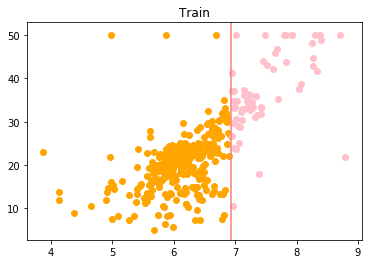

In [14]:
plt.scatter(X_l[:, col], y_l, color = 'orange')
plt.scatter(X_r[:, col], y_r, color = 'pink')
plt.axvline(threshold, color = 'salmon')
plt.title('Train')

In [15]:
y_pred = DecisionTree.predict(X_test)

In [16]:
y_test.shape

(152,)

In [17]:
X_l = X_test[X_test[:, col] <= threshold]
y_l = y_test[X_test[:, col] <= threshold]
X_r = X_test[X_test[:,col] > threshold]
y_r = y_test[X_test[:,col] > threshold]

y_l_pred = y_pred[X_test[:, col] <= threshold]
y_r_pred = y_pred[X_test[:,col] > threshold]

Text(0.5, 1.0, 'Test and predicted')

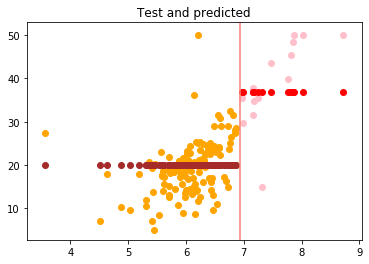

In [18]:
plt.scatter(X_l[:, col], y_l, color = 'orange')
plt.scatter(X_r[:, col], y_r, color = 'pink')

plt.scatter(X_l[:, col], y_l_pred, color = 'brown')
plt.scatter(X_r[:, col], y_r_pred, color = 'red')

plt.axvline(threshold, color = 'salmon')
plt.title('Test and predicted')

Как видно из графиков, predict действительно похож на среднее по двум классам, разделенным пороговым значением. И, получается, что мы предсказываем значение y достаточно неплохо для такой маленькой глубины дерева.

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters (`max_depth` and `min_samples_split`) on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `RMSE` on test dataset and hyperparameters of the best estimator. 

In [19]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':range(1, 10), 
              'min_samples_split' : range(1, 15),
              'min_samples_leaf':range(1, 5)}

DecisionTree = MyDecisionTreeRegressor()
gs = GridSearchCV(DecisionTree, parameters, scoring = 'neg_root_mean_squared_error', cv = 5, n_jobs = -1)
gs.fit(X_train,y_train)

print(f"Best parameters: {gs.best_params_}")
print(f"Best RMSE: {-1 * gs.best_score_}")

KeyboardInterrupt: 

### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use use the following algorithm to estimate bias^2 and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n\_iter}$. Each $X_i$ has $N$ observations (randomly selected from the original dataset with replacement)
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n\_iter}$, which contains all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on observations from $X_i$s and compute predictions on points from $Z_i$s
4. For a given *object* $x_n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $x_n$ was in OOB)
     - variance: variance of the predictions (predictions of the algorithms, for which $x_n$ was in OOB)
5. Average bias^2 and variance over all the points


**Consider a toy example.** You are given a dataset with 5 observations: $((x_1 ,y_1), (x_2, y_2), (x_3, y_3), (x_4, y_4), (x_5, y_5))$, where $x_i$ is a vector of features, $y_i$ is a target variable . And choose `n_iter` to be 3. 
* Example of bootstrapped samples:
$$X_1 = (x_2, x_5, x_2, x_3, x_2, x_5)$$
$$X_2 = (x_5, x_2, x_4, x_4, x_1, x_5)$$
$$X_3 = (x_1, x_3, x_1, x_4, x_3, x_1)$$

* Corresponding OOB samples:
$$Z_1 = (x_1, x_4)$$
$$Z_2 = (x_3)$$
$$Z_3 = (x_2, x_5)$$

* Fit models using $X_1$, $X_2$ and $X_3$ as training data. Use 1st model to make predictions for points from $Z_1$, second - for $Z_2$, etc. and use these predictions to estimate bias and variance. 

    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations `n_iter`). All other operations should be vectorized. 

P.S. These numpy functions might be usefull here `np.nanmean`, `np.nanstd` (but you are not obliged to use them). 

In [30]:
def get_bias_variance(estimator, x, y, n_iter):
    """ 
    Calculate bias^2 and variance of the `estimator`. Using a given dataset and bootstrap with `n_iter` samples. 

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in 
    Returns
    -------
    bias2 : float, 
        Estiamted squared bias
    variance : float, 
        Estiamted variance
    """
    
    np.random.seed(42)
    
    n = len(y)
    lst_pred = np.repeat(np.nan, n) #первую строку затем нужно будет удалить (но иначе не получится concatenate, vstack)
    for i in range(n_iter):
        #1.
        sample_indexes = np.random.choice(n, n, replace=True)
        sample_x = x[sample_indexes,:]
        sample_y = y[sample_indexes]
        #2.
        #Чтобы выбрать индексы, которые не попали в sample_index, нужно применить функцию isin и взять противоположные значения
        #np.arange берем, чтобы взять только те индексы из всех, 
        #на месте которых в условии стоит True (то есть они не попали в выборку) 
        not_sample_indexes = np.arange(n)[~np.isin(range(n), sample_indexes)]
        not_sample_x = x[not_sample_indexes,:]
        not_sample_y = y[not_sample_indexes]
        #3.
        estimator.fit(sample_x,sample_y)
        y_pred = estimator.predict(not_sample_x)

        res_i = np.repeat(np.nan, n)
        np.put(res_i, not_sample_indexes, y_pred)
        lst_pred = np.hstack((lst_pred, res_i))
        
    #4.
    #Нужно посчитать среднее по всем prediction, где индекс i попал в not_sample_indexes
    #lst_pred = np.column_stack(lst_pred)
    
    #lst_pred = lst_pred[:, 1:]
    lst_pred = lst_pred[1:]
    #bias = np.square(y - np.nanmean(lst_pred, axis = 1))
    bias = np.square(y - np.nanmean(lst_pred, axis = 0))
    #5.
    bias2 = np.nanmean(bias)
    #variance = np.nanmean(np.nanvar(lst_pred, axis = 1))
    variance = np.nanmean(np.nanvar(lst_pred, axis = 0))
    return bias2, variance

In [31]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, X_train, y_train, 10)

(87.95791984100343, 86.9508968762377)

### Task 7 <a id="task7"></a>  (0.5 points = 0.25 for code + 0.25 for comments)

Compute bias and variance for the trees of different depths. Plot how bias and variance change as depth increases. 

Comment on what you observe, how does your result correspond to what we have discussed in class?

In [22]:
bias_lst = []
variance_lst = []
for depth in range(1, 15):
    estimator = MyDecisionTreeRegressor(max_depth=depth, min_samples_split=14)
    bias, variance = get_bias_variance(estimator, X_train, y_train, 10)
    bias_lst.append(bias)
    variance_lst.append(variance)

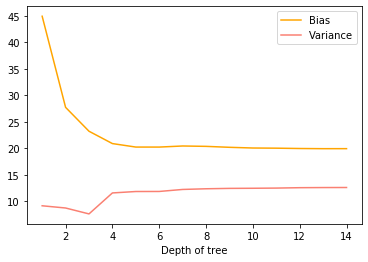

In [23]:
plt.plot(range(1, 15), bias_lst, color = 'orange', label = 'Bias')
plt.plot(range(1, 15), variance_lst, color = 'salmon', label = 'Variance')
plt.xlabel('Depth of tree')
plt.legend()
plt.show()

``` Мы знаем, что дисперсия отвечает по сути за переобучение. Поэтому закономерно, что при большой глубине дерева дисперсия начинает возрастать. Значит, происходит переобучение модели. Смещение (bias) напротив, отвечает за недообучение. Поэтому закономерно, что оно падает в зависимости о глубины (или почти не меняется на больших значениях) ```

### Task 8 <a id="task8"></a>  (0.5 points = 0.25 for code + 0.25 for comments)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments? 
 - Do your results align with the theory? Why?

In [24]:
from sklearn.ensemble import BaggingRegressor
#возьмем параметры модели из Task 6 для сравнения результатов
model = BaggingRegressor(base_estimator=MyDecisionTreeRegressor(max_depth=8, min_samples_split=15),
                         n_jobs=-1, n_estimators=100, random_state = 42)
get_bias_variance(model, X_train, y_train, 10)

(16.802448534553175, 1.7510161032150733)

```Как видно из результатов, bias и variance довольно сильно уменьшились. В теории, при баггинге должна уменьшаться variance, но если вдруг до этого variance параметр уже был оптимальный и лучший, то bias может и увеличиться. В нашем случае, оба параметра уменьшились, что говорит о том, что они не были оптимальными в предыдущем случае (individual tree). Получается, что результат согласуется с теорией.```

# Part 2. More Ensembles

In this part we will be working with [Thyroid Disease Data Set](https://archive.ics.uci.edu/ml/datasets/thyroid+disease) to solve a classification task. 

In [25]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('thyroid_disease.csv')

le = LabelEncoder()
y = le.fit_transform(df['Class'])
X = df.drop('Class', axis=1)
X.head(5)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source
0,41.0,F,f,f,f,f,f,f,f,f,...,2.5,t,125.0,t,1.14,t,109.0,f,NaN,SVHC
1,23.0,F,f,f,f,f,f,f,f,f,...,2.0,t,102.0,f,NaN,f,NaN,f,NaN,other
2,46.0,M,f,f,f,f,f,f,f,f,...,NaN,t,109.0,t,0.91,t,120.0,f,NaN,other
3,70.0,F,t,f,f,f,f,f,f,f,...,1.9,t,175.0,f,NaN,f,NaN,f,NaN,other
4,70.0,F,f,f,f,f,f,f,f,f,...,1.2,t,61.0,t,0.87,t,70.0,f,NaN,SVI


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding (take a look at the argument `drop` in [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to figure out the best way to apply OHE to binary variables)
    - Numeric: Fill missing values
    
Use `ColumnTranformer` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer)) to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transorm1, column_names1),
    ('name2', transorm2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer. 
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_transform = make_pipeline(
                                 transform_1,
                                 transform_2
                                )
```


P.S. Choose your favourite way to fill missing values. 

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns in the dataset. 

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

#0. Dropping columns with missing values
#Выражение X.isna().mean() показывает по сути процент nan в колонках. Нам нужно удалить те колонки, где NaN много.
#Возьмем в качестве порога 0.1 (так как 10% потери данных - это уже достаточно много)
X = X.drop(columns = (X.columns[X.isna().mean() > 0.1]).tolist())

#1. Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


#2. Fillilng missing values and applying one-hot-encoding
cat_columns = X.columns[X.dtypes == 'object']
num_columns = X.columns[X.dtypes != 'object']
print(len(cat_columns) + len(num_columns)) #видим, что все колонки распределились на categorical и numerical


# define column_transformer 
transform1 = OneHotEncoder()
transform2 = SimpleImputer(strategy='most_frequent')

categorical_transfrom = make_pipeline(transform1, transform2)
numerical_transfrom = SimpleImputer(strategy='mean')

column_transformer = ColumnTransformer(transformers= [('numerical', numerical_transfrom, num_columns),
                                                      ('categorical', categorical_transfrom, cat_columns)],
                                       remainder='passthrough')
# Transform the data
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

25


### Task 2 <a id="task2_2"></a> (0.7 points  = 0.4 for code + 0.3 for comments)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import accuracy_score

In [28]:
#Определяем все 5 моделей
models = [
    GradientBoostingClassifier(), RandomForestClassifier(),
    DecisionTreeClassifier(), SVC(), LogisticRegression()]
names = ['Gradient Boosting', 'Random Forest','Decision Tree','SVC','Logistic Regression']
cv = StratifiedKFold() # 5 splits - defeault

for i in range(len(models)):
    models[i].fit(X_train, y_train)
    #Частично код с семинара
    print(names[i])
    print(f'Score on Cross-Validation {cross_val_score(models[i], X_train, y_train, scoring="accuracy").mean():.4f}')
    print(f'Actual test score: {accuracy_score(models[i].predict(X_test), y_test):.4f}')


Gradient Boosting
Score on Cross-Validation 0.9295
Actual test score: 0.9488
Random Forest
Score on Cross-Validation 0.9330
Actual test score: 0.9488
Decision Tree
Score on Cross-Validation 0.9008
Actual test score: 0.9019
SVC
Score on Cross-Validation 0.9356
Actual test score: 0.9461
Logistic Regression
Score on Cross-Validation 0.9360
Actual test score: 0.9470


```Получается, что лучший accuracy score получается при использовании модели Random Forest и Gradient Boosting. Кажется, что Decision Tree модель могла переобучиться, потому что результат ощутимо меньше, чем для других моделей, и кроме того, decision tree в целом быстро переобучается. Остальные модели идут почти ровно. Вряд ли можно говорить о недообучении.```

### Task 3 <a id="task2_3"></a> (0.5 points = 0.4 for code + 0.1 for comments)

More Gradient Boosting. Choose one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 



In [29]:
# Я брала код частично из источника https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/

In [30]:
!pip install xgboost

In [31]:
import xgboost
from xgboost import XGBClassifier

In [33]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':range(1, 3), 
              'learning_rate' : [0.01, 0.1]}

model = XGBClassifier()
gs = GridSearchCV(model, parameters, scoring = 'neg_root_mean_squared_error', cv = 3, n_jobs = -1)
gs.fit(X_train,y_train)

print(f"Best parameters: {gs.best_params_}")

[17:50:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters: {'learning_rate': 0.01, 'max_depth': 1}


In [34]:
model = XGBClassifier(max_depth = 1, learning_rate = 0.01)
model.fit(X_train,y_train)

[17:50:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=1, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
print(f'{cross_val_score(model, X_train, y_train, scoring="accuracy").mean():.4f}')
print(f'test score: {accuracy_score(model.predict(X_test), y_test):.4f}')

[17:50:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:50:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

```На тесте accuracy оказалось примерно таким же, как и в предыдущих моделях. В принципе, качество хорошее и значимых отличий от предыдущих моделей я не вижу.```

### Task 4 <a id="task2_4"></a> (0.7 points = 0.4 for code + 0.3 for comments)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting as base estimators (use large amount of trees in gradient boosting, >100)
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) 
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfitting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

In [36]:
from sklearn.ensemble import BaggingClassifier

In [37]:
for max_depth in [2, 3, 5, 7]:
    BaggingDecisionTree = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth), 
                                            n_jobs=-1, n_estimators=100)
    BaggingDecisionTree.fit(X_train, y_train)
    print(f'Bagged Decision Tree with max_depth = {max_depth}: {accuracy_score(BaggingDecisionTree.predict(X_test), y_test):.4f}')

Bagged Decision Tree with max_depth = 2: 0.9461
Bagged Decision Tree with max_depth = 3: 0.9461
Bagged Decision Tree with max_depth = 5: 0.9488
Bagged Decision Tree with max_depth = 7: 0.9470


In [55]:
for max_depth in [2, 3, 5, 7]:
    BaggingGradientBoosting = BaggingClassifier(base_estimator=GradientBoostingClassifier(max_depth=max_depth),
                                            n_jobs=-1, n_estimators=200)
    BaggingGradientBoosting.fit(X_train, y_train)
    print(f'Bagged Gradient Boosting with max_depth = {max_depth}: {accuracy_score(BaggingGradientBoosting.predict(X_test), y_test):.4f}')

Bagged Gradient Boosting with max_depth = 2: 0.9496
Bagged Gradient Boosting with max_depth = 3: 0.9514
Bagged Gradient Boosting with max_depth = 5: 0.9523
Bagged Gradient Boosting with max_depth = 7: 0.9523


In [43]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [45]:
#код частично из документации по Voiting
clf1 = LogisticRegression(random_state=42)
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf3 = GaussianNB()
for voting in ['hard', 'soft']:
    Voting = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting = voting, n_jobs = -1)
    Voting.fit(X_train, y_train)
    print(f'VotingClissifier with voting = {voting}: {accuracy_score(Voting.predict(X_test), y_test):.4f}')                          

VotingClissifier with voting = hard: 0.9496
VotingClissifier with voting = soft: 0.9267


In [48]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [50]:
#Код взят частично из документации https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier
estimators = [('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
              ('svr', make_pipeline(StandardScaler(),LinearSVC(random_state=42)))]
StackingLogisticRegression = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs = -1)
StackingLogisticRegression.fit(X_train, y_train)
print(f'Stacking Logistic Regression: {accuracy_score(StackingLogisticRegression.predict(X_test), y_test):.4f}')      

Stacking Logistic Regression: 0.9488


In [53]:
for max_depth in [1, 2, 3, 5, 7]:
    StackingGradientBoosting = StackingClassifier(estimators=estimators,
                                                  final_estimator=GradientBoostingClassifier(max_depth = max_depth),
                                                  n_jobs = -1)
    StackingGradientBoosting.fit(X_train, y_train)
    print(f'Stacking Gradient Boosting with max_depth = {max_depth}: {accuracy_score(StackingGradientBoosting.predict(X_test), y_test):.4f}')    

Stacking Gradient Boosting with max_depth = 1: 0.9496
Stacking Gradient Boosting with max_depth = 2: 0.9532
Stacking Gradient Boosting with max_depth = 3: 0.9470
Stacking Gradient Boosting with max_depth = 5: 0.9355
Stacking Gradient Boosting with max_depth = 7: 0.9293


```Результаты сопоставимы. Но все-таки лучший результат по accuracy score получился в модели Stacking Classifier with Gradeint Boosting as a final model с максимальной глубиной = 2. ```
``` Баггинг действительно помогает gradient boosting, score увеличился на ~0.03. То есть переобучение меньше при большом количестве деревьев.```
```Stacking и Voiting различается тем, что Stacking использует final model как слой, обхединяющий все estimators. Voiting немного менее умный и использует их по отдельности. Значит, результат у Stacking должен быть чуть больше, как в принципе и получается в случае voting = soft, а в случае voting = hard результат не сильно отличается. ```

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to get on this dataset. 

In [54]:
StackingGradientBoosting = StackingClassifier(estimators=estimators,
                                                  final_estimator=GradientBoostingClassifier(max_depth = 2),
                                                  n_jobs = -1)
StackingGradientBoosting.fit(X_train, y_train)
print(f'Test score: {accuracy_score(StackingGradientBoosting.predict(X_test), y_test):.4f}')    

Test score: 0.9505


``` Получается, что 0.95 довольно высокая точность, которой удалось добиться.```